In [1]:
from logger import MyLogger
import time
import SubjObjLoader
import json
from torch import nn
import torch
from pytorch_transformers import *
import importlib
from collections import deque
# import dataloader
from BertRDMLoader import *
import json
from torch import nn
import torch
from pytorch_transformers import *
import importlib
from tensorboardX import SummaryWriter
import torch.nn.utils.rnn as rnn_utils
import tsentiLoader

In [2]:
import transformer_utils

In [3]:
import numpy as np
import matplotlib.pyplot as plt

### 工具函数

#### 画柱状图表达特征指标的变化

In [4]:
def plot_heatmap(heatmap, data_label, heat_max, heat_min, xlabel, ylabel, title, fontsize=None):
    #attention: [batch, seq_len]
    #data_label: [batch]
    batch = len(data_label)
    height = 0.5
    plt.figure(figsize=(50, batch*height))
    plt.ylim(0, batch*height)
    plt.xlim(0, 50)
    if fontsize is None:
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.yticks(np.arange(0, batch*height, height), data_label)
        plt.yticks(np.arange(0, 50, 5), ['']*10)
    else:
        plt.xlabel(xlabel, fontsize=fontsize)
        plt.ylabel(ylabel, fontsize=fontsize)
        plt.title(title, fontsize=fontsize)
        plt.yticks(np.arange(0, batch*height, height), data_label, fontsize=(fontsize/10))
#         plt.yticks(np.arange(0, 50, 5), ['']*10)
    
    for idx, h in enumerate(heatmap):
        color_list = [((b-heat_min)*1.0/(heat_max - heat_min), 0.0, 0.0) for b in h]
        d = np.arange(0, 50, 49.99/len(h)).tolist()
        d.reverse()
        color_list.reverse()
        for color, length in zip(color_list, d):
            plt.barh([idx*0.5], length, 1.0, color=color) 
    plt.show()

### 旧模型的评价

bert没有分到多块GPU上去进行计算

In [5]:
class pooling_layer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(pooling_layer, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.input_dim = input_dim
        self.output_dim = output_dim
        
    def forward(self, inputs):
        assert(inputs.ndim == 4 ) # [batchsize, max_seq_len, max_word_num, input_dim] 
        batch_size, max_seq_len, max_word_num, input_dim = inputs.shape
        assert(input_dim == self.input_dim)
        t_inputs = inputs.reshape([-1, self.input_dim])
        return self.linear(t_inputs).reshape(
            
            [-1, max_word_num, self.output_dim]
        
        ).max(axis=1)[0].reshape(
        
            [-1, max_seq_len, self.output_dim]
        
        )

class RDM_Model(nn.Module):
    def __init__(self, word_embedding_dim, sent_embedding_dim, hidden_dim, dropout_prob):
        super(RDM_Model, self).__init__()
        self.embedding_dim = sent_embedding_dim
        self.hidden_dim = hidden_dim
        self.gru_model = nn.GRU(word_embedding_dim, 
                                self.hidden_dim, 
                                batch_first=True, 
                                dropout=dropout_prob
                            )
        self.DropLayer = nn.Dropout(dropout_prob)
#         self.PoolLayer = pooling_layer(word_embedding_dim, sent_embedding_dim) 
        
    def forward(self, x_emb, x_len, init_states): 
        """
        input_x: [batchsize, max_seq_len, sentence_embedding_dim] 
        x_emb: [batchsize, max_seq_len, 1, embedding_dim]
        x_len: [batchsize]
        init_states: [batchsize, hidden_dim]
        """
        batchsize, max_seq_len, _ , emb_dim = x_emb.shape
#         pool_feature = self.PoolLayer(x_emb)
#         sent_feature = sentiModel( 
#                 x_emb.reshape(
#                     [-1, max_sent_len, emb_dim]
#                 ) 
#             ).reshape(
#                 [batchsize, max_seq_len, -1]
#             )
#         pooled_input_x_dp = self.DropLayer(input_x)
        pool_feature = x_emb.reshape(
                [-1, max_seq_len, emb_dim]
        )
        df_outputs, df_last_state = self.gru_model(pool_feature, init_states)
        hidden_outs = [df_outputs[i][:x_len[i]] for i in range(batchsize)]
        final_outs = [df_outputs[i][x_len[i]-1] for i in range(batchsize)]
        return hidden_outs, final_outs


class CM_Model(nn.Module):
    def __init__(self, sentence_embedding_dim, hidden_dim, action_num):
        super(CM_Model, self).__init__()
        self.sentence_embedding_dim = sentence_embedding_dim
        self.hidden_dim = hidden_dim
        self.action_num = action_num
#         self.PoolLayer = pooling_layer(self.embedding_dim, 
#                                             self.hidden_dim)
        self.DenseLayer = nn.Linear(self.hidden_dim, 64)
        self.Classifier = nn.Linear(64, self.action_num)
        
    def forward(self, rdm_model, s_model, rl_input, rl_state):
        """
        rl_input: [batchsize, max_word_num, sentence_embedding_dim]
        rl_state: [1, batchsize, hidden_dim]
        """
        assert(rl_input.ndim==3)
        batchsize, max_word_num, embedding_dim = rl_input.shape
#         assert(embedding_dim==self.embedding_dim)
        sentence = s_model(rl_input).reshape(batch_size, 1, self.sentence_embedding_dim)
#         pooled_rl_input = self.PoolLayer(
#             rl_input.reshape(
#                 [-1, 1, max_word_num, self.embedding_dim]
#             )
#         ).reshape([-1, 1, self.hidden_dim])
        
#         print("sentence:", sentence.shape)
#         print("rl_state:", rl_state.shape)
        rl_output, rl_new_state = rdm_model.gru_model(
                                            sentence, 
                                            rl_state
                                        )
        rl_h1 = nn.functional.relu(
            self.DenseLayer(
#                 rl_state.reshape([len(rl_input), self.hidden_dim]) #it is not sure to take rl_state , rather than rl_output, as the feature
                rl_output.reshape(
                    [len(rl_input), self.hidden_dim]
                )
            )
        )
        stopScore = self.Classifier(rl_h1)
        isStop = stopScore.argmax(axis=1)
        return stopScore, isStop, rl_new_state


# In[3]:


def layer2seq(bert, layer, cuda=False):
    if cuda:
        outs = [bert( torch.tensor([input_]).cuda())
                for input_ in layer]   
    else: 
        outs = [bert( torch.tensor([input_]))
                    for input_ in layer]
    states = [item[1] for item in outs]
    return rnn_utils.pad_sequence(states, batch_first=True)

def Word_ids2SeqStates(word_ids, bert, ndim, cuda=False):
    assert(ndim == 3)
    if cuda:
        embedding = [layer2seq(bert, layer, cuda) for layer in word_ids]
    else:
        embedding = [layer2seq(bert, layer) for layer in word_ids]
    return padding_sequence(embedding)


# In[4]:


def Count_Accs(ylabel, preds):
    correct_preds = np.array(
        [1 if y1==y2 else 0 
        for (y1, y2) in zip(ylabel, preds)]
    )
    y_idxs = [idx if yl >0 else idx - len(ylabel) 
            for (idx, yl) in enumerate(ylabel)]
    pos_idxs = list(filter(lambda x: x >= 0, y_idxs))
    neg_idxs = list(filter(lambda x: x < 0, y_idxs))
    acc = sum(correct_preds) / (1.0 * len(ylabel))
    if len(pos_idxs) > 0:
        pos_acc = sum(correct_preds[pos_idxs])/(1.0*len(pos_idxs))
    else:
        pos_acc = 0
    if len(neg_idxs) > 0:
        neg_acc = sum(correct_preds[neg_idxs])/(1.0*len(neg_idxs))
    else:
        neg_acc = 0
    return acc, pos_acc, neg_acc, y_idxs, pos_idxs, neg_idxs, correct_preds

def Loss_Fn(ylabel, pred_scores):
    diff = ((ylabel - pred_scores)*(ylabel - pred_scores)).mean(axis=1)
#     pos_neg = (1.0*sum(ylabel.argmax(axis=1)))/(1.0*(len(ylabel) - sum(ylabel.argmax(axis=1))))
    pos_neg = 0
    if pos_neg > 0:
        print("unbalanced data")
        weight = torch.ones(len(ylabel)).cuda() + (ylabel.argmax(axis=1).to(torch.float32)/(1.0*pos_neg)) - ylabel.argmax(axis=1).to(torch.float32)
        return (weight *diff).mean()
    else:
        print("totally unbalanced data")
        return diff.mean()



In [6]:
def eval(rdm_model, bert, rdm_classifier, 
                    tokenizer, new_data_len=[]):
    batch_size = 20 
    d_IDs = get_data_ID()
    t_steps=int(len(d_IDs)/batch_size)
    
    max_gpu_batch = 2 #cannot load a larger batch into the limited memory, but we could  accumulates grads
    splits = int(batch_size/max_gpu_batch)
    assert(batch_size%max_gpu_batch == 0)
    sum_loss = 0.0
    sum_acc = 0.0
    init_states = torch.zeros([1, max_gpu_batch, rdm_model.hidden_dim], dtype=torch.float32).cuda()
    weight = torch.tensor([2.0, 1.0], dtype=torch.float32).cuda()
    loss_fn = nn.CrossEntropyLoss(weight=weight)
    acc_l = np.zeros(splits)
    loss_l = np.zeros(splits)
    with torch.no_grad():
        for step in range(t_steps):
            try:
                for j in range(splits):
                    if len(new_data_len) > 0:
                        x, x_len, y = get_df_batch(step*splits+j, max_gpu_batch, new_data_len, tokenizer=tokenizer)
                    else:
                        x, x_len, y = get_df_batch(step, max_gpu_batch, tokenizer=tokenizer)
                    x_emb = Word_ids2SeqStates(x, bert, 3, cuda=True) 
                    batchsize, max_seq_len, max_sent_len,                                     emb_dim = x_emb.shape
                    rdm_hiddens, rdm_outs = rdm_model(x_emb, x_len, init_states)
                    rdm_scores = rdm_classifier(
                        torch.cat(
                            rdm_outs # a list of tensor, where the ndim of tensor is 1 and the shape of tensor is [hidden_size]
                        ).reshape(
                            [-1, rdm_model.hidden_dim]
                        )
                    )
                    rdm_preds = rdm_scores.argmax(axis=1)
                    y_label = y.argmax(axis=1)
                    acc_l[j], _, _, _, _, _, _ = Count_Accs(y_label, rdm_preds)
                    loss = loss_fn(rdm_scores, torch.tensor(y_label).cuda())
                    loss_l[j] = float(loss)
    #                 print("%d, %d | x_len:"%(step, j), x_len)
            except RuntimeError as exception:
                if "out of memory" in str(exception):
                    print("WARNING: out of memory")
                    print("%d, %d | x_len:"%(step, j), x_len)
                    if hasattr(torch.cuda, 'empty_cache'):
                        torch.cuda.empty_cache()
    #                     time.sleep(5)
                    raise exception
                else:   
                    raise exception
            sum_loss += loss_l.mean()
            sum_acc += acc_l.mean()
            print("loss:", loss_l.mean(), "acc:", acc_l.mean())
    mean_loss = sum_loss/(1.0*t_steps)
    mean_acc = sum_acc/(1.0*t_steps)
    print("mean_loss", mean_loss, " | mean_acc:", mean_acc)

In [7]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", cached_dir = "/home/hadoop/transformer_pretrained_models/bert-base-uncased-pytorch_model.bin")

bert = BertModel.from_pretrained("bert-base-uncased").cuda()

with open("config.json", "r") as cr:
    dic = json.load(cr)

class adict(dict):
    ''' Attribute dictionary - a convenience data structure, similar to SimpleNamespace in python 3.3
        One can use attributes to read/write dictionary content.
    '''
    def __init__(self, *av, **kav):
        dict.__init__(self, *av, **kav)
        self.__dict__ = self

FLAGS = adict(dic)
# In[10]:
load_data_fast()

data_ID = get_data_ID()

len(data_ID)

data = get_data()

{'bert-base-uncased': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-pytorch_model.bin', 'bert-large-uncased': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-pytorch_model.bin', 'bert-base-cased': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-pytorch_model.bin', 'bert-large-cased': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-pytorch_model.bin', 'bert-base-multilingual-uncased': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-pytorch_model.bin', 'bert-base-multilingual-cased': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-pytorch_model.bin', 'bert-base-chinese': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-pytorch_model.bin', 'bert-base-german-cased': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-cased-pytorch_model.bin', 'bert-large-uncased-whole-word-masking': 'https:/

#### 切分原数据集 | 3884: 200 :500

In [ ]:
load_data_fast()

_马晶那个数据集跟这个数据集差异太大，无法迁移_

``` python
data_ID = get_data_ID()
data_len = get_data_len()
data_y = get_data_y()

test_data_y = data_y[-500:]

test_data_len = data_len[-500:]

test_data_ID = data_ID[-500:]

np.save("data/data_ID.npy", np.array(data_ID)[:-500])
np.save("data/data_len.npy", np.array(data_len)[:-500])
np.save("data/data_y.npy", np.array(data_y)[:-500])

np.save("data/test_data_ID.npy", np.array(test_data_ID))
np.save("data/test_data_len.npy", np.array(test_data_len))
np.save("data/test_data_y.npy", np.array(test_data_y))
```

```python
data_ID = get_data_ID()
data_len = get_data_len()
data_y = get_data_y()

valid_data_y = data_y[-200:]

valid_data_len = data_len[-200:]

valid_data_ID = data_ID[-200:]

np.save("data/data_ID.npy", np.array(data_ID)[:-200])
np.save("data/data_len.npy", np.array(data_len)[:-200])
np.save("data/data_y.npy", np.array(data_y)[:-200])

np.save("data/valid_data_ID.npy", np.array(valid_data_ID))
np.save("data/valid_data_len.npy", np.array(valid_data_len))
np.save("data/valid_data_y.npy", np.array(valid_data_y))
```

```python
del data               
del data_ID              
del data_len               
del data_y             
del valid_data_ID            
del valid_data_len       
del valid_data_y            

from BertRDMLoader import data          
from BertRDMLoader import data_ID       
from BertRDMLoader import data_len      
from BertRDMLoader import data_y        
from BertRDMLoader import valid_data_ID 
from BertRDMLoader import valid_data_len
from BertRDMLoader import valid_data_y  
```

#### 创建测试所用模型

In [ ]:
rdm_model = RDM_Model(768, 300, 256, 0.2).cuda()
cm_model = CM_Model(300, 256, 2).cuda()
rdm_classifier = nn.Linear(256, 2).cuda()

In [15]:
senti_save_as = '/home/hadoop/ERD/RDMBertTrain/rdmModel_epoch019.pkl'

In [16]:
checkpoint = torch.load(senti_save_as)
bert.load_state_dict(checkpoint['bert'])

<All keys matched successfully>

``` python
torch.save(
                    {
                        "bert":bert.state_dict(),
                        "rmdModel":rdm_model.state_dict(),
                        "rdm_classifier": rdm_classifier.state_dict()
                    },
                    rdm_save_as
                )
```

In [17]:
rdm_model.load_state_dict(checkpoint['rmdModel'])

<All keys matched successfully>

In [18]:
rdm_classifier.load_state_dict(checkpoint['rdm_classifier'])

<All keys matched successfully>

#### test the bert embedding model on the trainning data

In [38]:
eval(rdm_model, bert, rdm_classifier, 
                    tokenizer)

loss: 0.11101210117340088 acc: 1.0


KeyboardInterrupt: 

In [31]:
lines = open("/home/hadoop/tmp_loss").readlines()

accs = [float(line.strip("\n").split("acc:")[1]) for line in lines]

mean_acc = np.array(accs).mean()

mean_acc

0.9475982532751092

In [33]:
r = torch.randn([3, 4])

In [34]:
r[:1]

tensor([[-1.9957, -0.4725,  0.5221,  0.0872]])

#### test the bert model on another data

In [15]:
load_test_data_fast()

max_sent: 187 ,  max_seq_len: 101
5802 data loaded


In [16]:
data_ID =  get_data_ID()

In [17]:
len(data_ID)

500

In [18]:
test_labels = np.array(get_data_y())
test_labels.sum(axis=0), test_labels.tolist()

(array([163., 337.]),
 [[0.0, 1.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [0.0, 1.0]

In [19]:
eval(rdm_model, bert, rdm_classifier, 
                    tokenizer)

loss: 0.07612740993499756 acc: 1.0
loss: 0.017561832442879677 acc: 1.0
loss: 0.6489768028259277 acc: 0.5


KeyboardInterrupt: 

### 新模型的评价

#### 新模型的模型部分

In [5]:
class pooling_layer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(pooling_layer, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.input_dim = input_dim
        self.output_dim = output_dim
        
    def forward(self, inputs):
        assert(inputs.ndim == 4 ) # [batchsize, max_seq_len, max_word_num, input_dim] 
        batch_size, max_seq_len, max_word_num, input_dim = inputs.shape
        assert(input_dim == self.input_dim)
        t_inputs = inputs.reshape([-1, self.input_dim])
        return self.linear(t_inputs).reshape(
            
            [-1, max_word_num, self.output_dim]
        
        ).max(axis=1)[0].reshape(
        
            [-1, max_seq_len, self.output_dim]
        
        )

class RDM_Model(nn.Module):
    def __init__(self, word_embedding_dim, sent_embedding_dim, hidden_dim, dropout_prob):
        super(RDM_Model, self).__init__()
        self.embedding_dim = sent_embedding_dim
        self.hidden_dim = hidden_dim
        self.gru_model = nn.GRU(word_embedding_dim, 
                                self.hidden_dim, 
                                batch_first=True, 
                                dropout=dropout_prob
                            )
        self.DropLayer = nn.Dropout(dropout_prob)
#         self.PoolLayer = pooling_layer(word_embedding_dim, sent_embedding_dim) 
        
    def forward(self, x_emb): 
        """
        input_x: [batchsize, max_seq_len, sentence_embedding_dim] 
        x_emb: [batchsize, max_seq_len, 1, embedding_dim]
        x_len: [batchsize]
        init_states: [batchsize, hidden_dim]
        """
        batchsize, max_seq_len, _ , emb_dim = x_emb.shape
        init_states = torch.zeros([1, batchsize, self.hidden_dim], dtype=torch.float32).cuda()
        pool_feature = x_emb.reshape(
                [-1, max_seq_len, emb_dim]
        )
        try:
            df_outputs, df_last_state = self.gru_model(pool_feature, init_states)
        except:
            print("Error:", pool_feature.shape, init_states.shape)
            raise
        # hidden_outs = [df_outputs[i][:x_len[i]] for i in range(batchsize)]
        # final_outs = [df_outputs[i][x_len[i]-1] for i in range(batchsize)]
        # return hidden_outs, final_outs
        return df_outputs


class CM_Model(nn.Module):
    def __init__(self, sentence_embedding_dim, hidden_dim, action_num):
        super(CM_Model, self).__init__()
        self.sentence_embedding_dim = sentence_embedding_dim
        self.hidden_dim = hidden_dim
        self.action_num = action_num
#         self.PoolLayer = pooling_layer(self.embedding_dim, 
#                                             self.hidden_dim)
        self.DenseLayer = nn.Linear(self.hidden_dim, 64)
        self.Classifier = nn.Linear(64, self.action_num)
        
    def forward(self, rdm_model, rl_input, rl_state):
        """
        rl_input: [batchsize, max_word_num, sentence_embedding_dim]
        rl_state: [1, batchsize, hidden_dim]
        """
        assert(rl_input.ndim==3)
        batchsize, max_word_num, embedding_dim = rl_input.shape
        rl_output, rl_new_state = rdm_model.gru_model(
                                            rl_input, 
                                            rl_state
                                        )
        rl_h1 = nn.functional.relu(
            self.DenseLayer(
#                 rl_state.reshape([len(rl_input), self.hidden_dim]) #it is not sure to take rl_state , rather than rl_output, as the feature
                rl_output.reshape(
                    [len(rl_input), self.hidden_dim]
                )
            )
        )
        stopScore = self.Classifier(rl_h1)
        isStop = stopScore.argmax(axis=1)
        return stopScore, isStop, rl_new_state

def Loss_Fn(ylabel, pred_scores):
    diff = ((ylabel - pred_scores)*(ylabel - pred_scores)).mean(axis=1)
#     pos_neg = (1.0*sum(ylabel.argmax(axis=1)))/(1.0*(len(ylabel) - sum(ylabel.argmax(axis=1))))
    pos_neg = 0
    if pos_neg > 0:
        print("unbalanced data")
        weight = torch.ones(len(ylabel)).cuda() + (ylabel.argmax(axis=1).to(torch.float32)/(1.0*pos_neg)) - ylabel.argmax(axis=1).to(torch.float32)
        return (weight *diff).mean()
    else:
        print("totally unbalanced data")
        return diff.mean()
    
def WeightsForUmbalanced(data_label):
    _, _, labels = data_label.shape
    label_cnt = data_label.reshape([-1, labels]).sum(axis=0)
    weights = 1.0/label_cnt
    normalized_weights = weights/sum(weights)
    return normalized_weights


# In[4]:


# x_new = [sent1, sent2, sent3, ...]　
# x_new -> x_old_emb [batchsize, seq_len, sent_emb]：#使用seq_info 将sent组装回去
# ---> [batchsize, max_seq_len, sent_emb] # padding 成一个可以计算的batch, 从而可以切分
def rdm_data2bert_tensors(data_X, cuda):
    def padding_sent_list(sent_list):
        sent_len = [len(sent) for sent in sent_list]
        max_sent_len = max(sent_len)
        sent_padding = torch.zeros([len(sent_list), max_sent_len], dtype=torch.int64)
        attn_mask = torch.ones_like(sent_padding)
        for i, sent in enumerate(sent_list):
            sent_padding[i][:len(sent)] = torch.tensor(sent, dtype=torch.int32)
            attn_mask[i][len(sent):].fill_(0)
        return sent_padding, attn_mask
    sent_list = []
    [sent_list.extend(seq) for seq in data_X]
    seq_len = [len(seq) for seq in data_X]
    sent_tensors, attn_mask = padding_sent_list(sent_list)
    if cuda:
        sent_tensors = sent_tensors.cuda()
        attn_mask = attn_mask.cuda()
    return sent_tensors, attn_mask, seq_len

def subj_data2bert_tensors(sent_list, cuda):
    sent_len = [len(sent) for sent in sent_list]
    max_sent_len = max(sent_len)
    sent_padding = torch.zeros([len(sent_list), max_sent_len], dtype=torch.int64)
    attn_mask = torch.ones_like(sent_padding)
    for i, sent in enumerate(sent_list):
        sent_padding[i][:len(sent)] = torch.tensor(sent, dtype=torch.int32)
        attn_mask[i][len(sent):].fill_(0)
    if cuda:
        sent_padding = sent_padding.cuda()
        attn_mask = attn_mask.cuda()
    return sent_padding, attn_mask

def senti_data2bert_tensors(sent_list, cuda):
    sent_len = [len(sent) for sent in sent_list]
    max_sent_len = max(sent_len)
    sent_padding = torch.zeros([len(sent_list), max_sent_len], dtype=torch.int64)
    attn_mask = torch.ones_like(sent_padding)
    for i, sent in enumerate(sent_list):
        sent_padding[i][:len(sent)] = torch.tensor(sent, dtype=torch.int32)
        attn_mask[i][len(sent):].fill_(0)
    if cuda:
        sent_padding = sent_padding.cuda()
        attn_mask = attn_mask.cuda()
    return sent_padding, attn_mask


#### 模型的评价函数

In [6]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [7]:
load_data_fast()

max_sent: 187 ,  max_seq_len: 101
5802 data loaded


In [7]:
def eval_rdm(rdm_model, bert, rdm_classifier, 
                    tokenizer, new_data_len=[], cuda=True):
    batch_size = 20 
    d_IDs = get_data_ID()
    t_steps=int(len(d_IDs)/batch_size)
    assert(batch_size%max_gpu_batch == 0)
    sum_loss = 0.0
    sum_acc = 0.0
    init_states = torch.zeros([1, max_gpu_batch, rdm_model.hidden_dim], dtype=torch.float32).cuda()
    weight = torch.tensor([2.0, 1.0], dtype=torch.float32).cuda()
    loss_fn = nn.CrossEntropyLoss(weight=weight)

    labels = []
    preds = []
    with torch.no_grad():
        for step in range(t_steps):
            x, x_len, y = get_df_batch(step, batch_size, tokenizer=tokenizer)
            sent_tensors, attn_mask, seq_len = rdm_data2bert_tensors(x, cuda)
            bert_outs = bert(sent_tensors, attention_mask=attn_mask)
            pooled_sents = [bert_outs[1][sum(seq_len[:idx]):sum(seq_len[:idx])+seq_len[idx]] for idx, s_len in enumerate(seq_len)]
            data_tensors = rnn_utils.pad_sequence(pooled_sents, batch_first=True).unsqueeze(-2)
            rdm_hiddens = rdm_model(data_tensors)
            batchsize, _, _ = rdm_hiddens.shape
            rdm_outs = torch.cat(
                [ rdm_hiddens[i][x_len[i]-1] for i in range(batchsize)] 
                # a list of tensor, where the ndim of tensor is 1 and the shape of tensor is [hidden_size]
            ).reshape(
                [-1, rdm_model.hidden_dim]
            )
            rdm_scores = rdm_classifier(
                rdm_outs
            )
            rdm_preds = rdm_scores.argmax(axis=1)
            y_label = torch.tensor(y).argmax(axis=1).cuda() if cuda else torch.tensor(y).argmax(axis=1)

            labels.append(y_label)
            preds.append(rdm_preds)

            loss = loss_fn(rdm_scores, y_label)
            sum_loss += loss
            torch.cuda.empty_cache()
    mean_loss = sum_loss/(1.0*t_steps)

    rdm_preds = torch.cat(preds, axis=0) if not cuda else torch.cat(preds, axis=0).cpu()
    y_label = torch.cat(labels, axis=0) if not cuda else torch.cat(labels, axis=0).cpu()
    macro_precision, micro_precision, precision = precision_score(y_label, rdm_preds, average="macro"), precision_score(y_label, rdm_preds, average="micro"), precision_score(y_label, rdm_preds, average=None)
    macro_recall, micro_recall, recall = recall_score(y_label, rdm_preds, average="macro"), recall_score(y_label, rdm_preds, average="micro"), recall_score(y_label, rdm_preds, average=None)
    acc = accuracy_score(y_label, rdm_preds)
    macro_f1, micro_f1, f1 = f1_score(y_label, rdm_preds, average="macro"), f1_score(y_label, rdm_preds, average="micro"), f1_score(y_label, rdm_preds, average=None)
    return mean_loss, (macro_precision, micro_precision, precision), (macro_recall, micro_recall, recall), acc, (macro_f1, micro_f1, f1)

In [8]:
def get_data_by_idxs(data_idxs, new_data_len=[], tokenizer=None):
    batchsize = len(data_idxs)
    m_data_y = np.zeros([batchsize, 2], dtype=np.int32)
    m_data_len = np.zeros([batchsize], dtype=np.int32)
    data_x = [] #[batchsize, seq_len, sent_len]
    if len(new_data_len) > 0:
        t_data_len = new_data_len
    else:
        t_data_len = data_len
    
    for i in range(batchsize):
        idx = data_idxs[i]
        m_data_y[i] = data_y[idx]
        m_data_len[i] = t_data_len[idx]
        seq_x = [
            tokenizer.encode(
                ' '.join([word for word in data[data_ID[idx]]['text'][j].split() if not word.__contains__('@')]),
                add_special_tokens=True
            )
            for j in range(t_data_len[idx])
        ]
        data_x.append(seq_x)
    return data_x, m_data_len, m_data_y

In [9]:
with open("config.json", "r") as cr:
    dic = json.load(cr)

class adict(dict):
    ''' Attribute dictionary - a convenience data structure, similar to SimpleNamespace in python 3.3
        One can use attributes to read/write dictionary content.
    '''
    def __init__(self, *av, **kav):
        dict.__init__(self, *av, **kav)
        self.__dict__ = self

FLAGS = adict(dic)

#### 创建模型并导入测试模型

In [12]:
tokenizer = BertTokenizer.from_pretrained("./bertModel/")
bert = BertModel.from_pretrained("./bertModel/").cuda()
rdm_model = RDM_Model(768, 300, 256, 0.2).cuda()
rdm_classifier = nn.Linear(256, 2).cuda()

/home/hadoop/.conda/envs/torch_B/lib/python3.6/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [12]:
device_ids = [0]
bert = nn.DataParallel(bert, device_ids=device_ids)
device_name = "cuda:%d"%device_ids[0]
device = torch.device(device_name)
bert.to(device)

DataParallel(
  (module): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

#### 测试RDM模型

_显然这个模型的挑选时机不好，过拟合了，应当挑选一个在开发集上最好的模型_

In [8]:
pretrained_file = "./MTLRDM/rdmModel_epoch199.pkl"
checkpoint = torch.load(pretrained_file)
bert.load_state_dict(checkpoint['bert'])
rdm_model.load_state_dict(checkpoint["rmdModel"])
rdm_classifier.load_state_dict(checkpoint["rdm_classifier"])

<All keys matched successfully>

In [22]:
load_data_fast()
eval_rdm(rdm_model, bert, rdm_classifier, 
                    tokenizer, new_data_len=[])

max_sent: 187 ,  max_seq_len: 101
5802 data loaded
loss: 0.0013149792794138193 acc: 1.0
loss: 0.0008682012557983398 acc: 1.0
loss: 0.0011640170123428106 acc: 1.0
loss: 0.0019624531269073486 acc: 1.0
loss: 0.0012935230042785406 acc: 1.0
loss: 0.0010040828492492437 acc: 1.0
loss: 0.0012245089747011662 acc: 1.0
loss: 0.03089812584221363 acc: 1.0
loss: 0.0006210895953699946 acc: 1.0
loss: 0.0008620548178441823 acc: 1.0
loss: 0.0008964042062871158 acc: 1.0
loss: 0.0012937907595187426 acc: 1.0
loss: 0.0007344117620959878 acc: 1.0
loss: 0.0011110963532701135 acc: 1.0
loss: 0.0009626635583117604 acc: 1.0
loss: 0.0013735622633248568 acc: 1.0
loss: 0.001495623611845076 acc: 1.0
loss: 0.0015656640753149986 acc: 1.0
loss: 0.001469327020458877 acc: 1.0
loss: 0.001017270260490477 acc: 1.0
loss: 0.0010514497989788651 acc: 1.0
loss: 0.0009182266076095402 acc: 1.0
loss: 0.0010460523189976811 acc: 1.0
loss: 0.002764412434771657 acc: 1.0
loss: 0.0009817044483497739 acc: 1.0
loss: 0.0009120305185206234 ac

KeyboardInterrupt: 

In [61]:
load_test_data_fast()
eval_rdm(rdm_model, bert, rdm_classifier, 
                    tokenizer, new_data_len=[])

max_sent: 187 ,  max_seq_len: 101
5802 data loaded


(tensor(1.4481, device='cuda:0'),
 (0.6215083798882681, 0.674, array([0.5       , 0.74301676])),
 (0.6124501647521436, 0.674, array([0.43558282, 0.78931751])),
 0.674,
 (0.615520698195542, 0.674, array([0.46557377, 0.76546763])))

#### 测试数据集中的情感变化

In [10]:
def rdm_seq_data2scores_seq(rdm_data, bert, task_emb, classifier, label_num =2):
    batch_size = 20
    scores = []
    with torch.no_grad():
        for i in range(int(len(rdm_data)/batch_size)):
            x = rdm_data[i*batch_size:min((i+1)*batch_size, len(rdm_data))]
            sent_tensors, attn_mask, seq_len = rdm_data2bert_tensors(x, cuda)
            xsj_embs, _ = bert(sent_tensors, attention_mask=attn_mask)
            tensors = xsj_embs + task_emb
            subj_feature = transformer(tensors, attention_mask = attn_mask)
            cls_feature = subj_feature[0][:, 0]
            subj_scores = classifier(cls_feature).softmax(axis=1)
            torch.cuda.empty_cache()
            print("subj_scores:", subj_scores.shape)
            seq_len.insert(0, 0)
            print("seq_len:", seq_len)
            for j in range(len(seq_len)-1):
                scores.append(subj_scores[sum(seq_len[:j]):sum(seq_len[:j])+seq_len[j+1], 1].tolist())
    return scores

In [38]:
import seaborn as sns

In [119]:
def plot_hist(x_tuples, bins, xlabel, ylabel, legends, title):
    colors = [(1, 0, 0), (1, 1, 0), (0, 1, 0,), (0, 0, 1)]
    def normfun(x,mu,sigma):
        pdf = np.exp(-((x - mu)**2)/(2*sigma**2)) / (sigma * np.sqrt(2*np.pi))
        return pdf
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim(0, 1)
    for i in range(len(x_tuples)):
        sns.distplot(x_tuples[i], bins=bins, rug=False, kde=True, hist=True, norm_hist=True, label=legends[i], hist_kws={"histtype": "step", "linewidth": 2,
        "alpha": 1}, kde_kws={"color": colors[0], "lw": 0, "label": ""})

###### 旧模型，nn.Transformer

In [10]:
task_embedding = nn.Embedding(3, 768)

encoder_layer = nn.TransformerEncoderLayer(768, 8)
transformer_encoder = nn.TransformerEncoder(encoder_layer, 1)

subj_cls = nn.Linear(768, 2)

transformer = transformer_encoder.cuda()
task_embedding = task_embedding.cuda()
subj_cls = subj_cls.cuda()

senti_cls = nn.Linear(768, 2).cuda()

In [14]:
joint_save_as = '/home/hadoop/ERD/MTLTrain/jointModel_epoch015.pkl'
checkpoint = torch.load(joint_save_as)
senti_cls.load_state_dict(checkpoint['senti_classifier'])
bert.load_state_dict(checkpoint['bert'])
transformer.load_state_dict(checkpoint['transformer'])
task_embedding.load_state_dict(checkpoint['task_embedding'])
subj_cls.load_state_dict(checkpoint['subj_classifier'])

<All keys matched successfully>

###### 新模型, BertEncoder

In [12]:
tt = BertTokenizer.from_pretrained("./bertModel/")
bb = BertModel.from_pretrained("./bertModel/")
task_embedding = nn.Embedding(3, 768)
trans_conf = adict({
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 1,
  "num_labels": 2,
  "output_attentions": False,
  "output_hidden_states": False,
  "torchscript": False
})
BertEncoder = transformer_utils.BertEncoder
transformer = BertEncoder(trans_conf)



bert = bb.cuda()
transformer = transformer.cuda()
task_embedding = task_embedding.cuda()
senti_cls = nn.Linear(768, 2).cuda()
rdm_model = RDM_Model(768, 300, 256, 0.2).cuda()
rdm_classifier = nn.Linear(256, 2).cuda()

/home/hadoop/.conda/envs/torch_B/lib/python3.6/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [33]:
joint_save_as = './SubjRDM/subj_best_Model.pkl'
checkpoint = torch.load(joint_save_as)
bert.load_state_dict(checkpoint['bert'])
transformer.load_state_dict(checkpoint['transformer'])
task_embedding.load_state_dict(checkpoint['task_embedding'])
subj_cls.load_state_dict(checkpoint['subj_classifier'])

FileNotFoundError: [Errno 2] No such file or directory: './SentiRDM/subj_best_Model.pkl'

###### 导入数据集

In [127]:
load_test_data_fast()

max_sent: 187 ,  max_seq_len: 101
5802 data loaded


In [128]:
del data
del data_ID
del data_len
del data_y

from BertRDMLoader import data
from BertRDMLoader import data_ID
from BertRDMLoader import data_len
from BertRDMLoader import data_y

In [15]:
pos_idxs = [idx for idx, d_y in enumerate(data_y) if d_y[1]==1]
neg_idxs = [idx for idx, d_y in enumerate(data_y) if d_y[0]==1]

In [16]:
n_data_ID=[data_ID[idx] for idx in neg_idxs[:20]]

n_head_text = [data[ID]['text'][0] for ID in n_data_ID]

In [17]:
p_data_ID=[data_ID[idx] for idx in pos_idxs[:20]]

p_head_text = [data[ID]['text'][0] for ID in p_data_ID]

In [18]:
pos_samples = random.sample(pos_idxs, 100)

In [19]:
neg_samples = random.sample(pos_idxs, 100)

In [20]:
pos_x, pos_len, labels = get_data_by_idxs(pos_idxs, tokenizer=tt)

In [21]:
neg_x, neg_len, labels = get_data_by_idxs(neg_idxs, tokenizer=tt)

In [22]:
cuda = True
subj_task_id = torch.tensor([1]).cuda() if cuda else torch.tensor([1])
task_emb = task_embedding(subj_task_id)

In [24]:
pos_scores = rdm_seq_data2scores_seq(pos_x, bert, task_emb, subj_cls, label_num =2)
neg_scores = rdm_seq_data2scores_seq(neg_x, bert, task_emb, subj_cls, label_num =2) 

subj_scores: torch.Size([362, 2])
seq_len: [0, 35, 18, 25, 19, 9, 10, 34, 19, 7, 11, 20, 29, 25, 12, 13, 8, 20, 20, 14, 14]
subj_scores: torch.Size([500, 2])
seq_len: [0, 41, 14, 49, 26, 17, 83, 22, 9, 7, 20, 26, 11, 16, 6, 20, 12, 23, 18, 23, 57]
subj_scores: torch.Size([463, 2])
seq_len: [0, 19, 8, 28, 20, 20, 16, 72, 8, 23, 10, 6, 31, 37, 27, 11, 39, 28, 46, 6, 8]
subj_scores: torch.Size([555, 2])
seq_len: [0, 30, 24, 30, 10, 20, 27, 28, 90, 29, 14, 34, 9, 24, 20, 20, 101, 8, 15, 11, 11]
subj_scores: torch.Size([409, 2])
seq_len: [0, 8, 20, 9, 11, 21, 19, 12, 9, 24, 23, 20, 18, 13, 9, 65, 23, 8, 8, 25, 64]
subj_scores: torch.Size([518, 2])
seq_len: [0, 96, 10, 40, 8, 9, 19, 14, 16, 13, 18, 11, 18, 9, 16, 16, 25, 56, 8, 48, 68]
subj_scores: torch.Size([362, 2])
seq_len: [0, 6, 10, 11, 11, 35, 10, 14, 22, 17, 41, 20, 35, 24, 9, 21, 16, 20, 8, 11, 21]
subj_scores: torch.Size([428, 2])
seq_len: [0, 21, 23, 15, 28, 101, 13, 25, 23, 18, 20, 21, 20, 31, 8, 7, 10, 19, 8, 9, 8]
subj_scores: 

In [75]:
neg_data, _, _ = get_data_by_idxs(neg_samples, tokenizer=tt)
heat_neg = rdm_seq_data2scores_seq(neg_data, bert, task_emb, subj_cls, label_num =2)
neg_ID = [data_ID[idx] for idx in neg_samples]
heat_max = np.concatenate(heat_neg).max()
heat_min = np.concatenate(heat_neg).min()

subj_scores: torch.Size([512, 2])
seq_len: [0, 101, 12, 12, 7, 19, 27, 27, 6, 31, 20, 9, 29, 25, 8, 11, 15, 9, 20, 23, 101]
subj_scores: torch.Size([448, 2])
seq_len: [0, 7, 46, 6, 11, 10, 26, 8, 30, 21, 9, 19, 13, 28, 18, 16, 35, 28, 18, 16, 83]
subj_scores: torch.Size([429, 2])
seq_len: [0, 14, 18, 6, 8, 41, 60, 23, 20, 8, 7, 6, 24, 23, 41, 20, 13, 40, 25, 18, 14]
subj_scores: torch.Size([392, 2])
seq_len: [0, 17, 16, 11, 24, 9, 25, 8, 11, 11, 26, 18, 15, 13, 42, 31, 19, 35, 26, 18, 17]
subj_scores: torch.Size([463, 2])
seq_len: [0, 101, 21, 10, 22, 19, 23, 18, 7, 25, 15, 20, 56, 22, 13, 18, 8, 29, 21, 8, 7]


In [77]:
heat_max, heat_min

(0.8973376154899597, 0.5942243337631226)

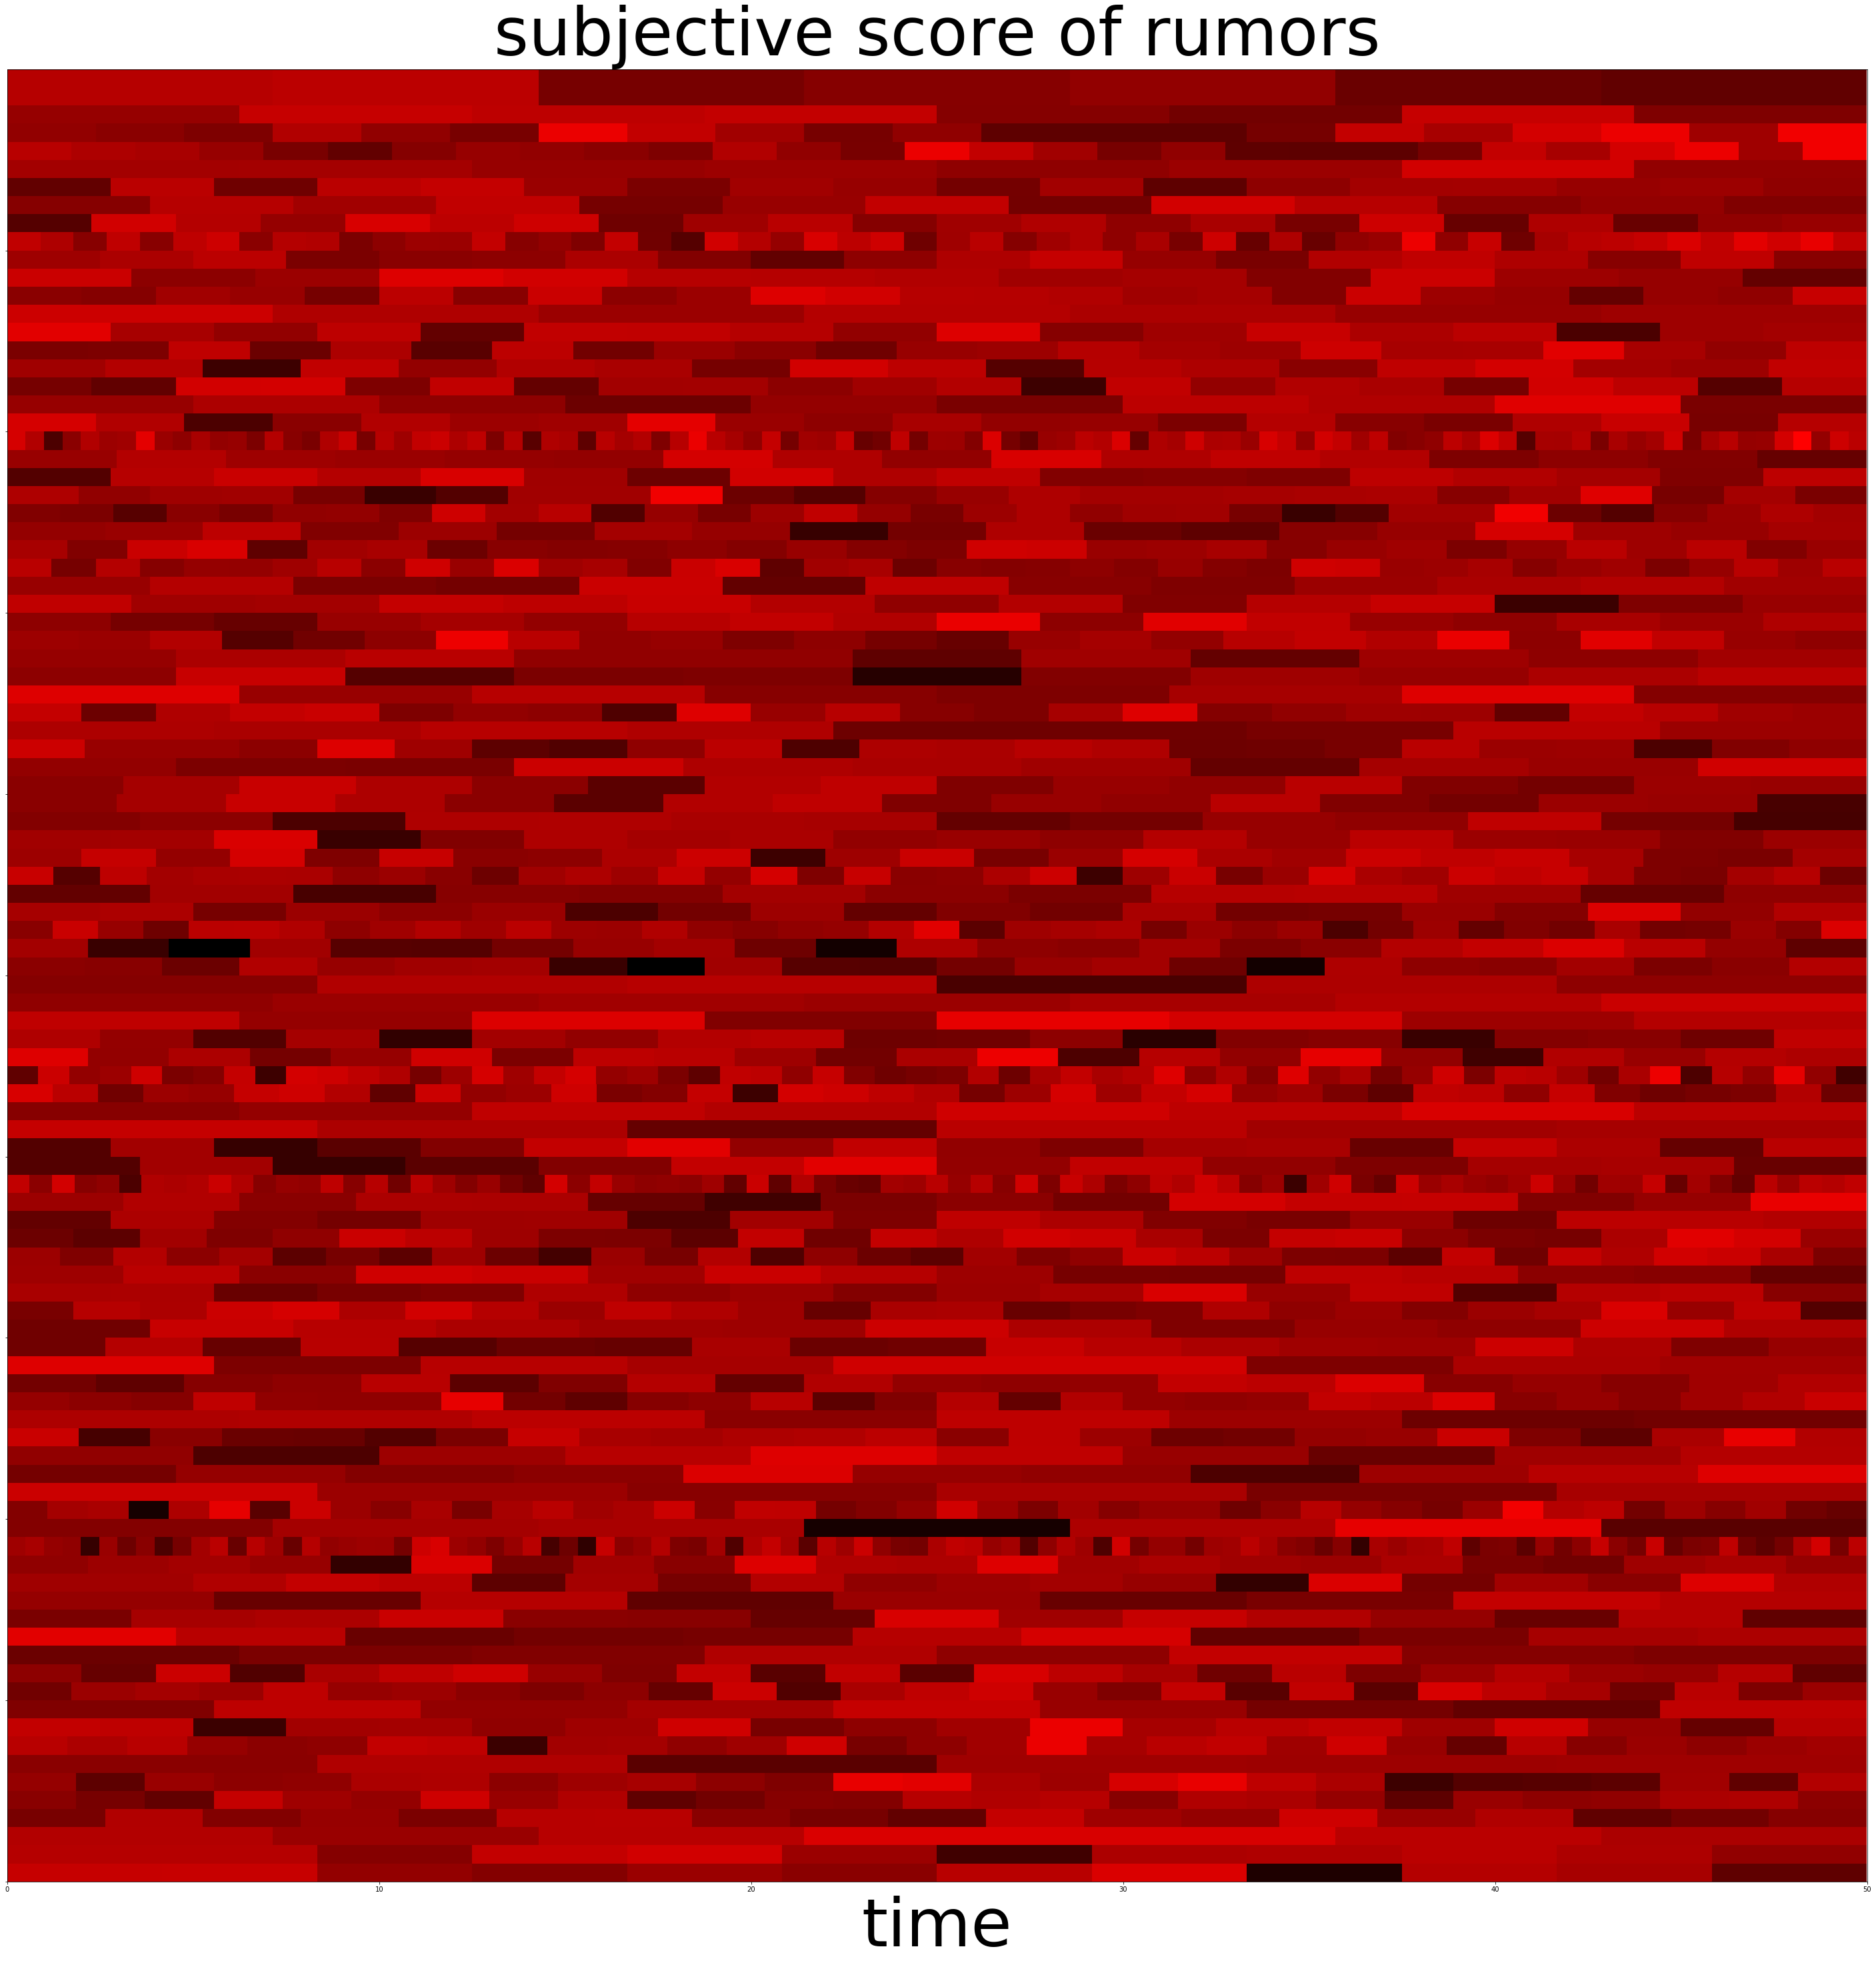

In [78]:
plot_heatmap(heat_neg, neg_ID, heat_max, heat_min, "time", "", "subjective score of rumors", 100)

In [66]:
pos_data, _, _ = get_data_by_idxs(pos_samples, tokenizer=tt)
heat_pos = rdm_seq_data2scores_seq(pos_data, bert, task_emb, subj_cls, label_num =2)
pos_ID = [data_ID[idx] for idx in pos_samples]
heat_max = np.concatenate(heat_pos).max()
heat_min = np.concatenate(heat_pos).min()

subj_scores: torch.Size([356, 2])
seq_len: [0, 9, 8, 12, 19, 14, 26, 20, 8, 7, 16, 11, 21, 34, 19, 18, 11, 53, 11, 15, 24]
subj_scores: torch.Size([497, 2])
seq_len: [0, 8, 15, 8, 6, 31, 37, 46, 25, 8, 37, 33, 20, 14, 8, 29, 20, 23, 83, 19, 27]
subj_scores: torch.Size([366, 2])
seq_len: [0, 7, 34, 14, 19, 18, 8, 21, 6, 21, 15, 9, 46, 8, 18, 20, 41, 24, 20, 10, 7]
subj_scores: torch.Size([375, 2])
seq_len: [0, 11, 12, 10, 101, 11, 21, 20, 11, 16, 8, 10, 16, 18, 10, 9, 12, 30, 12, 29, 8]
subj_scores: torch.Size([467, 2])
seq_len: [0, 21, 33, 14, 11, 20, 8, 21, 28, 22, 39, 101, 27, 9, 19, 23, 9, 19, 15, 18, 10]


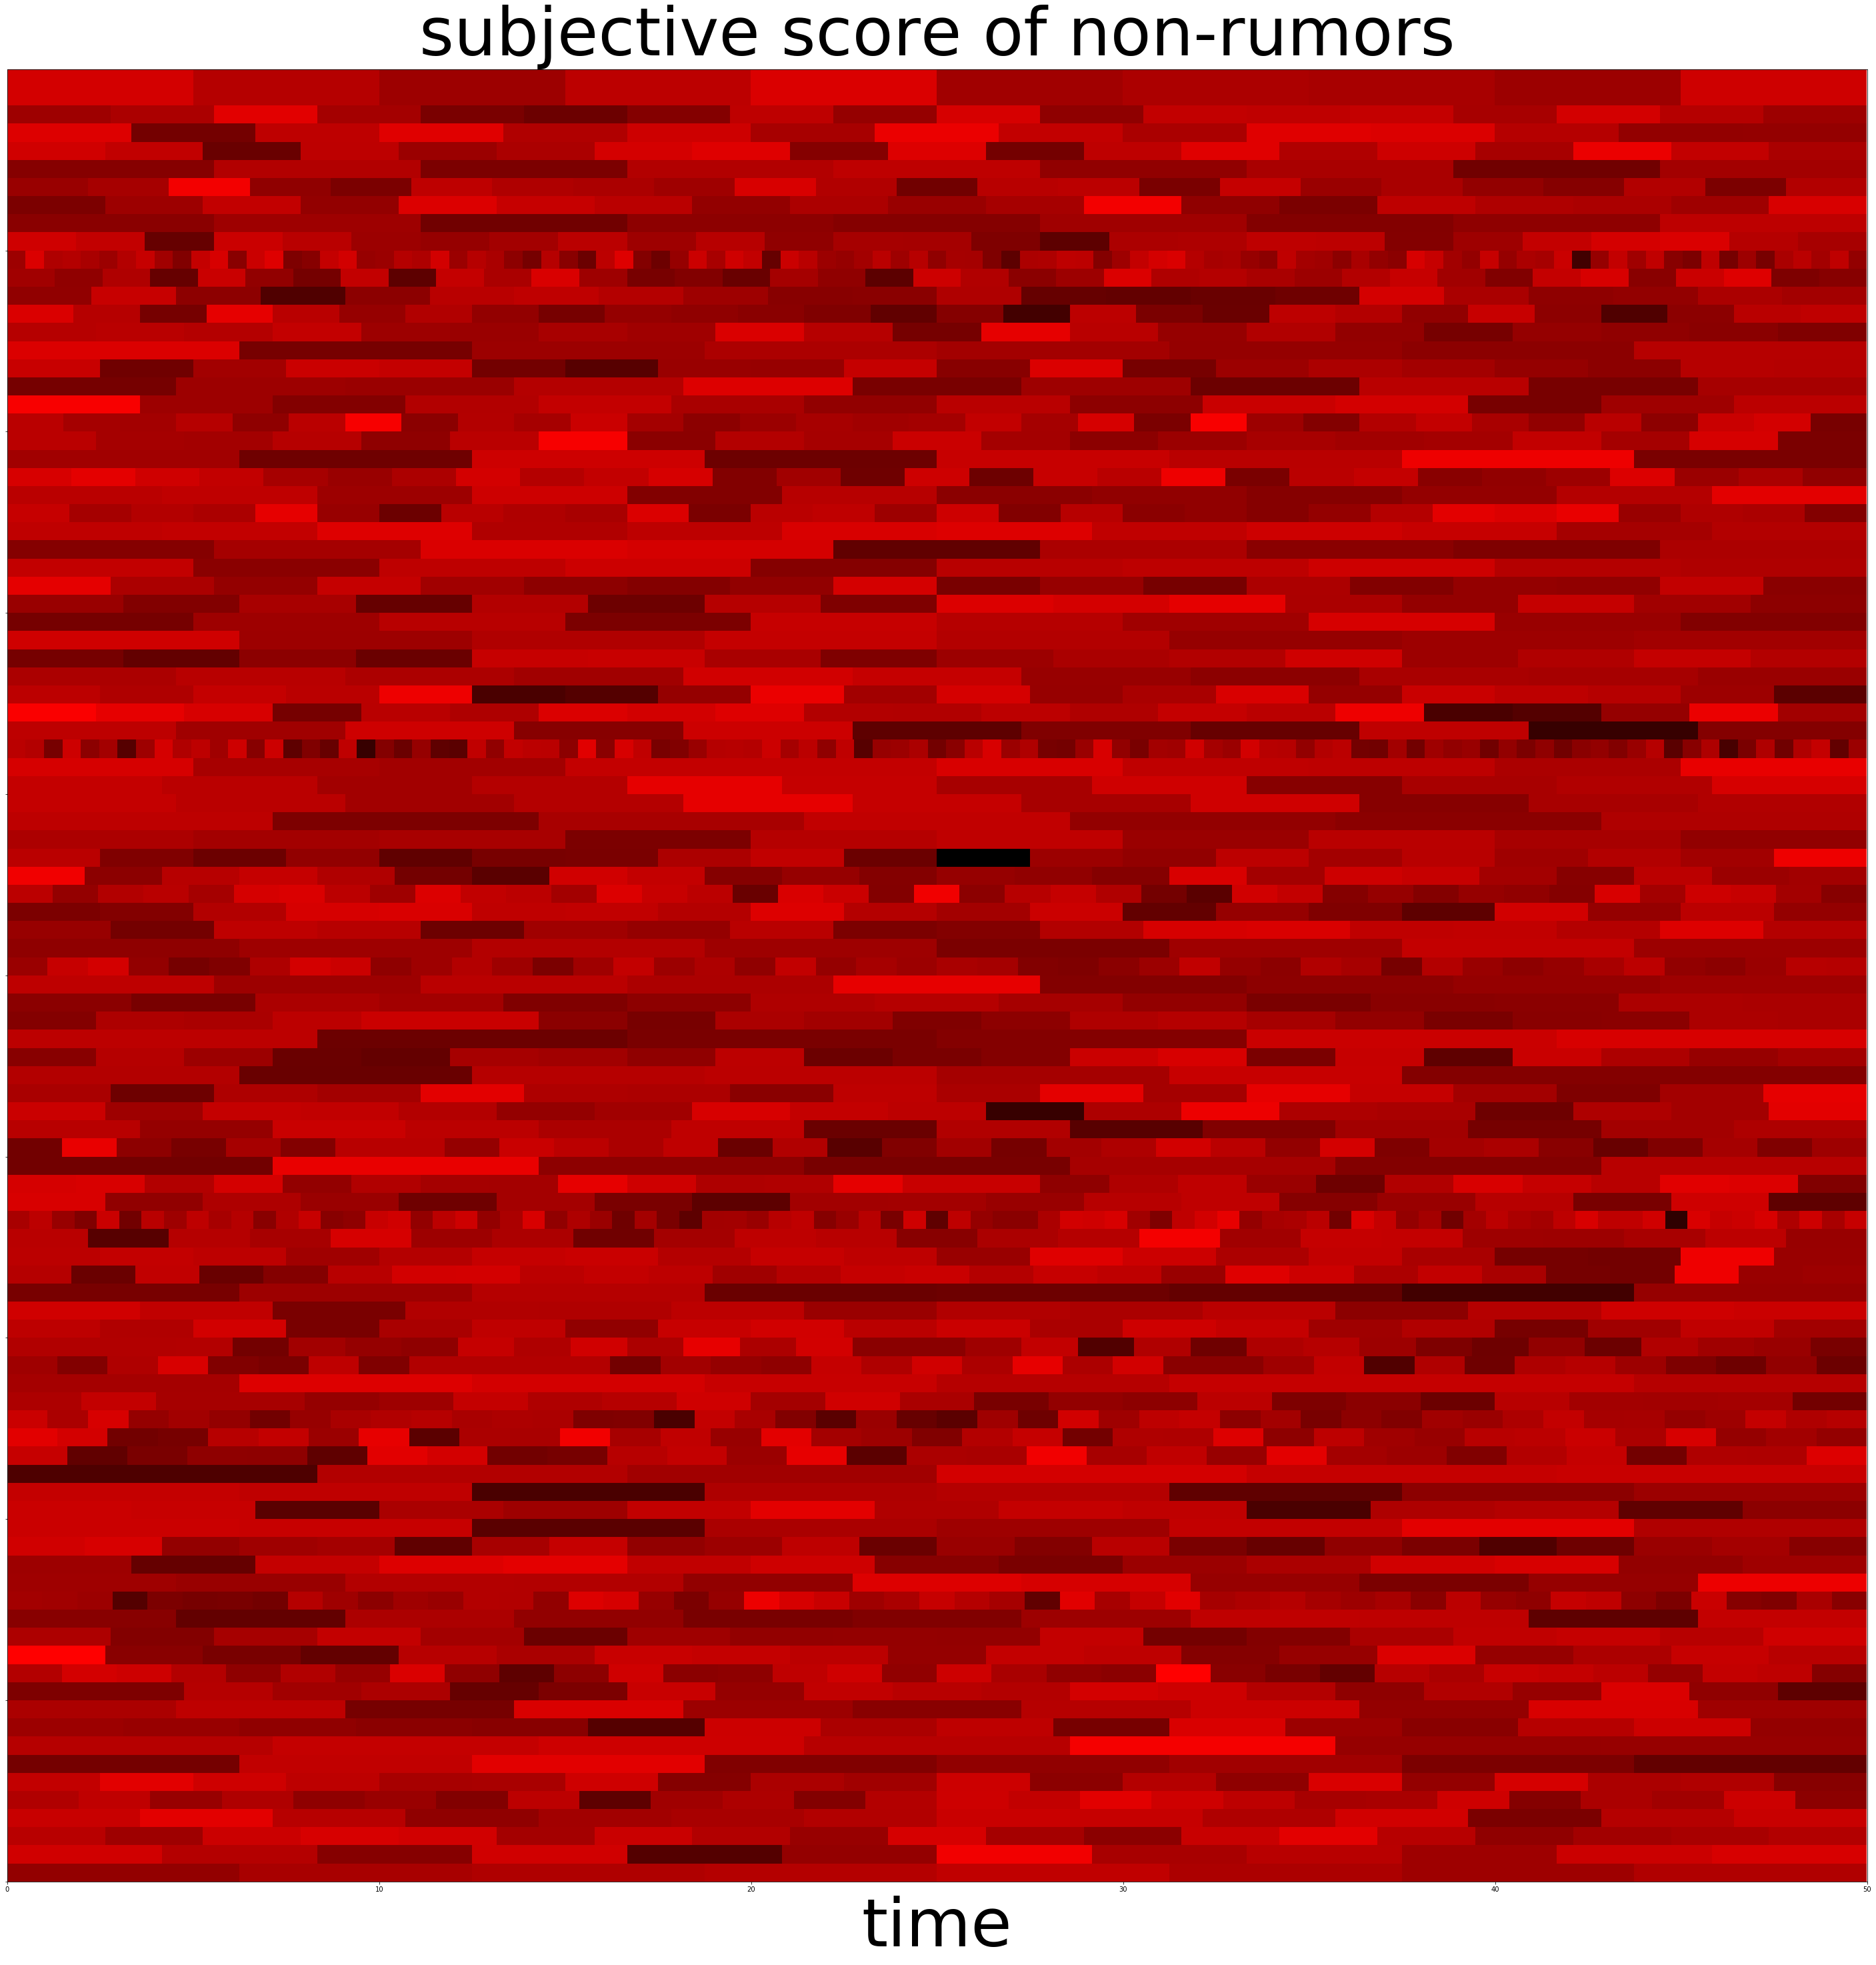

In [74]:
plot_heatmap(heat_pos, pos_ID, heat_max, heat_min, "time", "", "subjective score of non-rumors", 100)

In [42]:
neg_head = [h[0] for h in neg_scores]
neg_snd = [h[1] for h in neg_scores]
neg_tail = [h[-1] for h in neg_scores]

pos_head = [h[0] for h in pos_scores]
pos_snd = [h[1] for h in pos_scores]
pos_tail = [h[-1] for h in pos_scores]

/home/hadoop/.conda/envs/torch_B/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.


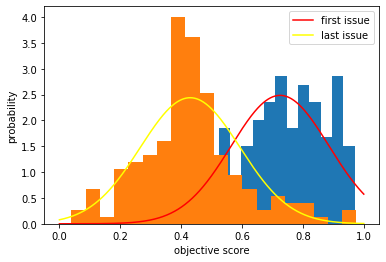

In [44]:
plot_hist((neg_head, neg_tail), 20, "objective score", "probability", ["first issue", "last issue"])

/home/hadoop/.conda/envs/torch_B/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.


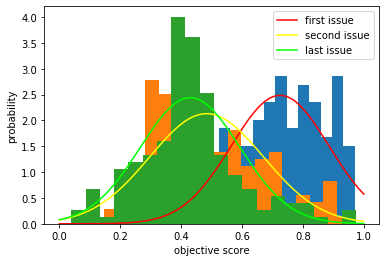

In [45]:
plot_hist((neg_head, neg_snd, neg_tail), 20, "objective score", "probability", ["first issue", "second issue", "last issue"])

/home/hadoop/.conda/envs/torch_B/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.


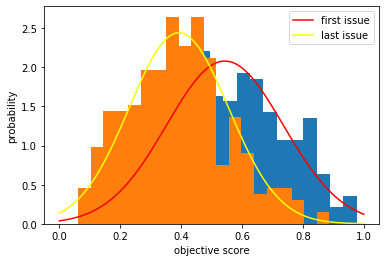

In [29]:
plot_hist((pos_head, pos_tail), 20, "objective score", "probability", ["first issue", "last issue"])

/home/hadoop/.conda/envs/torch_B/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.


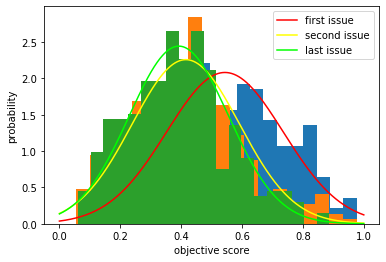

In [46]:
plot_hist((pos_head, pos_snd, pos_tail), 20, "objective score", "probability", ["first issue", "second issue", "last issue"])

/home/hadoop/.conda/envs/torch_B/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.


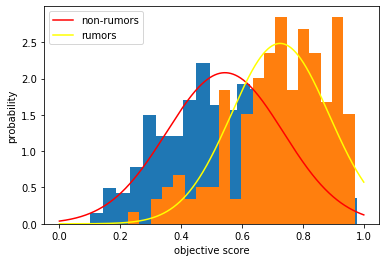

In [30]:
plot_hist((pos_head, neg_head), 20, "objective score", "probability", ["non-rumors", "rumors"])

###### 情感的变化

_情感分类器本身并不合理，得到的结果并不是在０~1之间均匀分布，即将所有的情感都笼统地分类为正面情感了。这样显然是不合情理的，尽管它在验证集上的分数确实很高_

In [23]:
tt = BertTokenizer.from_pretrained("./bertModel/")
bb = BertModel.from_pretrained("./bertModel/")
task_embedding = nn.Embedding(3, 768)
trans_conf = adict({
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 1,
  "num_labels": 2,
  "output_attentions": False,
  "output_hidden_states": False,
  "torchscript": False
})
BertEncoder = transformer_utils.BertEncoder
transformer = BertEncoder(trans_conf)



bert = bb.cuda()
transformer = transformer.cuda()
task_embedding = task_embedding.cuda()
senti_cls = nn.Linear(768, 2).cuda()
rdm_model = RDM_Model(768, 300, 256, 0.2).cuda()
rdm_classifier = nn.Linear(256, 2).cuda()

In [24]:
joint_save_as = './SentiRDM/senti_best_Model.pkl'
checkpoint = torch.load(joint_save_as)
senti_cls.load_state_dict(checkpoint['senti_classifier'])
bert.load_state_dict(checkpoint['bert'])

<All keys matched successfully>

In [25]:
transformer.load_state_dict(checkpoint['transformer'])
task_embedding.load_state_dict(checkpoint['task_embedding'])

<All keys matched successfully>

In [26]:
cuda = True
senti_task_id = torch.tensor([0]) if not cuda else torch.tensor([0]).cuda()
task_emb = task_embedding(senti_task_id)

In [27]:
pos_senti = rdm_seq_data2scores_seq(pos_x, bert, task_emb, senti_cls, label_num =2)
neg_senti = rdm_seq_data2scores_seq(neg_x, bert, task_emb, senti_cls, label_num =2) 

subj_scores: torch.Size([362, 2])
seq_len: [0, 35, 18, 25, 19, 9, 10, 34, 19, 7, 11, 20, 29, 25, 12, 13, 8, 20, 20, 14, 14]
subj_scores: torch.Size([500, 2])
seq_len: [0, 41, 14, 49, 26, 17, 83, 22, 9, 7, 20, 26, 11, 16, 6, 20, 12, 23, 18, 23, 57]
subj_scores: torch.Size([463, 2])
seq_len: [0, 19, 8, 28, 20, 20, 16, 72, 8, 23, 10, 6, 31, 37, 27, 11, 39, 28, 46, 6, 8]
subj_scores: torch.Size([555, 2])
seq_len: [0, 30, 24, 30, 10, 20, 27, 28, 90, 29, 14, 34, 9, 24, 20, 20, 101, 8, 15, 11, 11]
subj_scores: torch.Size([409, 2])
seq_len: [0, 8, 20, 9, 11, 21, 19, 12, 9, 24, 23, 20, 18, 13, 9, 65, 23, 8, 8, 25, 64]
subj_scores: torch.Size([518, 2])
seq_len: [0, 96, 10, 40, 8, 9, 19, 14, 16, 13, 18, 11, 18, 9, 16, 16, 25, 56, 8, 48, 68]
subj_scores: torch.Size([362, 2])
seq_len: [0, 6, 10, 11, 11, 35, 10, 14, 22, 17, 41, 20, 35, 24, 9, 21, 16, 20, 8, 11, 21]
subj_scores: torch.Size([428, 2])
seq_len: [0, 21, 23, 15, 28, 101, 13, 25, 23, 18, 20, 21, 20, 31, 8, 7, 10, 19, 8, 9, 8]
subj_scores: 

In [28]:
neg_st_head = [h[0] for h in neg_senti]
neg_st_tail = [h[-1] for h in neg_senti]

pos_st_head = [h[0] for h in pos_senti]
pos_st_tail = [h[-1] for h in pos_senti]

In [29]:
np.concatenate(pos_senti).max(), np.concatenate(neg_senti).max()

(0.9999274015426636, 0.9999444484710693)

In [30]:
np.concatenate(pos_senti).min(), np.concatenate(neg_senti).min()

(0.0008117920951917768, 0.001182842068374157)

###### sentiment 140训练出来的模型

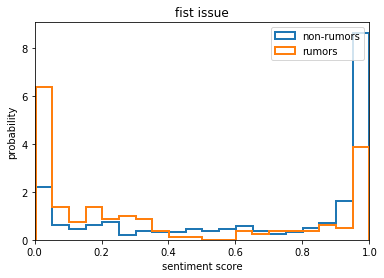

In [121]:
plot_hist((pos_st_head, neg_st_head), 20, "sentiment score", "probability", ["non-rumors", "rumors"], "fist issue")

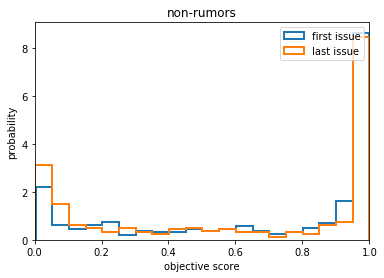

In [122]:
plot_hist((pos_st_head, pos_st_tail), 20, "objective score", "probability", ["first issue", "last issue"], "non-rumors")

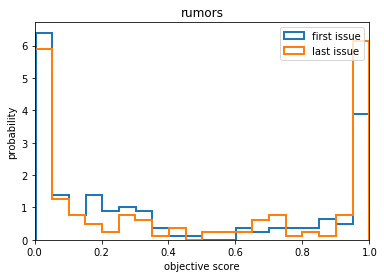

In [123]:
plot_hist((neg_st_head, neg_st_tail), 20, "objective score", "probability", ["first issue", "last issue"], "rumors")

###### SST训练出来的模型的结果

/home/hadoop/.conda/envs/torch_B/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


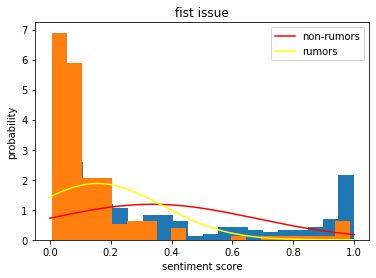

In [32]:
plot_hist((pos_st_head, neg_st_head), 20, "sentiment score", "probability", ["non-rumors", "rumors"], "fist issue")

/home/hadoop/.conda/envs/torch_B/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


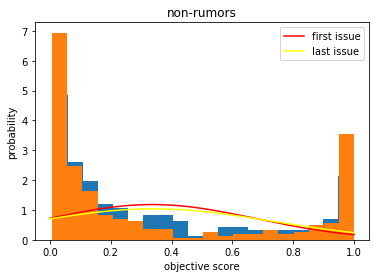

In [33]:
plot_hist((pos_st_head, pos_st_tail), 20, "objective score", "probability", ["first issue", "last issue"], "non-rumors")

/home/hadoop/.conda/envs/torch_B/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


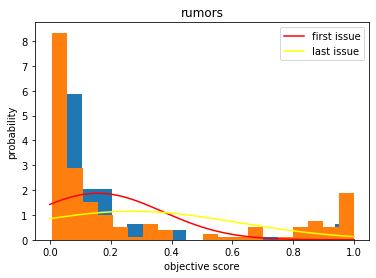

In [34]:
plot_hist((neg_st_head, neg_st_tail), 20, "objective score", "probability", ["first issue", "last issue"], "rumors")

In [125]:
sentence_idx = [idx for idx, senti in enumerate(pos_senti[0]) if senti>0.5]
pos_senti[0], sentence_idx

([0.38536107540130615,
  0.9972338080406189,
  0.24457614123821259,
  0.5060946345329285,
  0.9038814306259155,
  0.9996280670166016,
  0.4116199016571045,
  0.9840630292892456,
  0.9993477463722229,
  0.5902238488197327,
  0.869082510471344,
  0.9547634720802307,
  0.974891722202301,
  0.982952356338501,
  0.14214713871479034,
  0.24227507412433624,
  0.9073774814605713,
  0.13145054876804352,
  0.11536313593387604,
  0.8558561205863953,
  0.437100350856781,
  0.8639921545982361,
  0.07460072636604309,
  0.9736904501914978,
  0.914201021194458,
  0.5062513947486877,
  0.9583731889724731,
  0.9647663831710815,
  0.01982760801911354,
  0.9917536973953247,
  0.010537991300225258,
  0.3655124008655548,
  0.9755293130874634,
  0.9995013475418091,
  0.5632264614105225],
 [1,
  3,
  4,
  5,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  16,
  19,
  21,
  23,
  24,
  25,
  26,
  27,
  29,
  32,
  33,
  34])

In [48]:
list(zip([data[p_data_ID[0]]['text'][idx] for idx in sentence_idx], [pos_senti[0][idx] for idx in sentence_idx]))

[('@bbcnews @bbcr4today lol', 0.7670888900756836),
 ('@donshappelle @mrswobbitt @bbcr4today every cloud has a (govt surveillance) silver lining',
  0.6670747995376587),
 ("@mrchrisjohn @bbcr4today insane, part of organised plan...whatever. it's certainly put australia on the map of islamic issues.",
  0.9722060561180115),
 ('@mrswobbitt @bbcr4today australia has always been involved in all conflicts in #iraq and #afghanistan - oz public now realising the cost',
  0.7047157883644104),
 ("@mrchrisjohn @bbcr4today that's what i meant chris. the public are also realising that the threat is real for them too",
  0.9090205430984497),
 ('@mrchrisjohn @bbcr4today mmmmm. so far above we can only guess.',
  0.9399580955505371),
 ('@mrswobbitt charisma, presence and education - #bush could only wish for any of them',
  0.9908570647239685)]

In [129]:
list(zip([data[p_data_ID[0]]['text'][idx] for idx in sentence_idx], [pos_senti[0][idx] for idx in sentence_idx]))

[('@bbcr4today a poundland terrorist perhaps? #sydneysiege',
  0.9972338080406189),
 ('@bbcr4today as if it matters…sophisticated or not, people are still held hostage',
  0.5060946345329285),
 ('@bbcr4today surely the gun is the important bit?', 0.9038814306259155),
 ('@bbcnews @bbcr4today lol', 0.9996280670166016),
 ('@bbcr4today @bbcnews im pretty sure he wanted is flag or what ever! but m also sure al-qaeda used this flag. in there videos',
  0.9840630292892456),
 ("@bbcr4today @bbcnews how does he know he's got the wrong flag? he can imbue it with whatever meaning he likes",
  0.9993477463722229),
 ('@mrswobbitt @bbcr4today no of course not - just annoys me people automatically tag the event as directly related to #syria and #iraq',
  0.5902238488197327),
 ('@bbcr4today @bbcworld not terrorists, but they are religious lunatics',
  0.869082510471344),
 ("@mrchrisjohn @mrswobbitt @bbcr4today  maybe that's the point of the operation.",
  0.9547634720802307),
 ('@donshappelle @mrswobb

### 早期检测的评价

#### 可视化log文件中的reward

In [26]:
def logfile2rewardlist(logfile):
    steps = []
    rewards = []
    stage_steps = []
    stage_rewards = []
    with open(logfile) as fr:
        for line in fr:
            if line.__contains__('reward'):
                step, reward = line.strip('\n').split(',')
                step_num = int(step.strip("step:"))
                reward_num = float(reward.split('(')[1].strip(")"))
                if step_num != 1:
                    stage_steps.append(step_num)
                    stage_rewards.append(reward_num)
                else:
                    if len(stage_steps) != 0:
                        steps.append(stage_steps)
                        rewards.append(stage_rewards)
                        stage_steps = []
                        stage_rewards = []
                    stage_steps.append(step_num)
                    stage_rewards.append(reward_num)
        steps.append(stage_steps)
        rewards.append(stage_rewards)
    return steps, rewards

In [38]:
def VisualRewardList(reward_tuples, legends):
    plt.xlabel("step")
    plt.ylabel("reward")
#     plt.title(title)
    lines = []
    for (steps, rewards) in reward_tuples:
        l = plt.scatter(steps, rewards)
        lines.append(l)
    plt.legend(lines, legends)

In [27]:
steps, rewards = logfile2rewardlist("/home/hadoop/Downloads/ERD_PT7(2).log")    

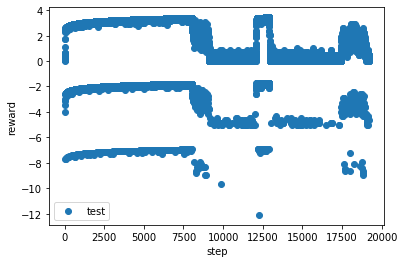

In [39]:
VisualRewardList(zip(steps, rewards), ["test"])

In [11]:
line = "step: 19199 , reward: tensor(-0.0100)"